## PERT

In [1]:
from collections import deque
import numpy as np
import scipy.stats as stats
from typing import List, Tuple
import matplotlib.pyplot as plt

### Zadanie 1 i 2

In [2]:
def calculateT0(tc, tm, tp):
  return (tc + 4 * tm + tp) / 6

def calculateVariancy(tp, tc):
  return (tp - tc) ** 2 / 36

def distribuant(X, mu=0, sigma=1):
  return stats.norm.cdf(X, mu, sigma)

def inverseDistribuant(P, mu=0, sigma=1):
  return stats.norm.ppf(P, mu, sigma)

In [3]:
# class Node represents activity in the network
class Node:
  def __init__(self, name, tc, tm, tp):
    self.name = name
    self.tc = tc
    self.tm = tm
    self.tp = tp
    self.t0 = calculateT0(tc, tm, tp)
    self.variancy = calculateVariancy(tp, tc)
    self.predecessors = []
    self.neighbors = []
    self.z = 0
    #earliest and latest start and finish times
    self.es = 0
    self.ef = 0
    self.ls = float('inf')
    self.lf = float('inf')
    
  def addPredecessor(self, node):
    self.predecessors.append(node)
    
  def addNeighbor(self, node):
    self.neighbors.append(node)
    
  def __repr__(self):
    return f'{self.name}'
  
  def printStartFinish(self):
    print(f'{self.name}: {self.es}/{self.ef}/{self.ls}/{self.lf}')

In [4]:
class Graph:
  def __init__(self, tasks):
    self.tasks = tasks
    self.start = tasks[0]
    self.end = tasks[-1]
    self.criticalPath = []
    self.completion = None
    
  def computeEarliest(self):
    # przechodzimy po wszystkich wierzchołkach "warstwami" czyli robimy bfs,w którym obliczamy najwcześniejszy czas rozpoczęcia i zakończenia
    q = deque()
    q.append(self.start)
    while q:
      node : "Node"= q.popleft()
      # obliczamy najwcześniejszy czas zakończenia wierzchołka jako maksimum z najwcześniejszych czasów zakończenia jego poprzedników (ponieważ muszą one się zakończyć zanim zacznie się nowe zadanie)
      m = 0
      for prev in node.predecessors:
        if prev.ef > m:
          m = prev.ef
      # obliczone maksimum zapisujemy jako najwcześniejszy czas rozpoczęcia i na bazie przewidywanego czasu trwania zadania obliczamy najwcześniejszy czas zakończenia
      node.es = m
      node.ef = m + node.t0
      # dodajemy do kolejki sąsiadów wierzchołka  
      for neighbor in node.neighbors:
        q.append(neighbor)
      
      # jeżeli dotarliśmy do końca sieci, to zapisujemy czas zakończenia jako czas zakończenia sieci
      if node == self.end:
        self.completion = node.ef
        return self.completion
        
  def computeLatest(self):
    # jest to analogiczny algorytm do obliczania najwcześniejszych czasów, ale tym razem obliczamy najpóźniejsze czasy rozpoczęcia i zakończenia idąc od końca sieci
    q = deque()
    node = self.end
    node.z = 0
    node.lf = node.ef
    node.ls = node.es
    for prev in self.end.predecessors:
      q.append(prev)
    while q:
      node = q.popleft()
      m = self.completion
      for neighbor in node.neighbors:
        if neighbor.ls < m:
          m = neighbor.ls
      node.lf = m
      node.ls = m - node.t0
      node.z = (node.ls - node.es) 
      for prev in node.predecessors:
        q.append(prev)
    
  def PERT(self):
    # algorytm PERT wywołuje obliczenie najwcześniejszych i najpóźniejszych czasów rozpoczęcia i zakończenia
    self.computeEarliest()
    self.computeLatest()
    # a następnie wyznacza ścieżkę krytyczną algorytmem dfs, suzkając wierzchołków, których możliwe przesunięcie jest równe 0
    node = self.start
    path = []
    def dfs(node):
      nonlocal path
      # jezeli dotarliśmy do końca ścieżki, to sprawdzamy czy jest ona dłuższa od dotychczasowej ścieżki krytycznej i ją zapisujemy
      if node == self.end:
        path.append(node)
        if len(path) > len(self.criticalPath):
          self.criticalPath = path.copy()
        return
      # jeżeli wierzchołek ma możliwe przesunięcie równe 0, to dodajemy go do ścieżki i szukamy w jego sąsiedztwie
      if node.z == 0:
        path.append(node)
        for neighbor in node.neighbors:
          dfs(neighbor)
        path.pop()
   
    dfs(self.start)
    return self.criticalPath
  
  def totalVariance(self):
    # oblicza wariancję całkowitą, jako sumę wariancji wierzchołków w ścieżce krytycznej
    return sum([node.variancy for node in self.criticalPath])
  
  def drawGanttsChart(self):
    # Funkcja rysująca wykres Gantta za pomocą biblioteki matplotlib.pyplot
    plt.title('Gantt chart')
    plt.xlim(0, self.completion + 1)
    # rysowanie zadań
    for node in self.tasks[::-1]:
      for neighbor in node.neighbors:
        # dorysowanie przerywanej linii, określającej możliwe przesunięcie zadania oraz zależności między zadaniami
        plt.plot([node.ef, neighbor.es], [neighbor.name, neighbor.name], 'r--', linewidth=1)
      # dorysowanie linii końcowej zadania
      if node.neighbors:
        plt.plot([node.ef, node.ef], [node.name, node.neighbors[-1].name], 'r--', linewidth=1)
      plt.plot([node.es, node.ef], [node.name, node.name], color='skyblue', linewidth=5)
    plt.grid(True)
    plt.show()
    
    
  def computeTime(self, probability):
    return inverseDistribuant(probability, self.completion, np.sqrt(self.totalVariance()))

Ścieżka krytyczna: [A, C, F, H, J]
Czas trwania dla prawdopodobieństwa 0.9 wynosi 81.0


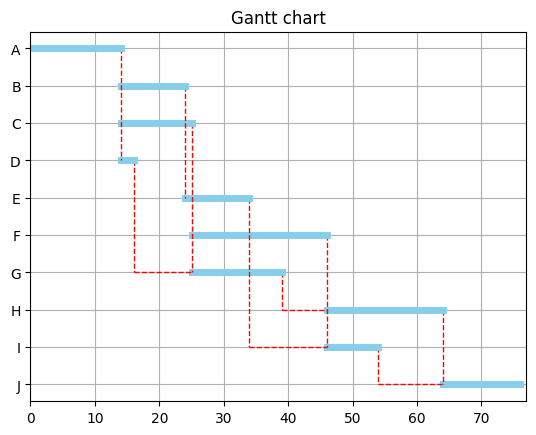

In [5]:
def main():
  # ustalenie czynosci i ich czasu trwania
  tasks : List["Node"]= [
      Node('A', 13, 14, 15),
      Node('B', 5, 10, 15),
      Node('C', 7, 10, 19),
      Node('D', 2, 2, 2),
      Node('E', 10, 10, 10),
      Node('F', 20, 21, 22),
      Node('G', 4, 16, 16),
      Node('H', 5, 20, 23),
      Node('I', 5, 8, 11),
      Node('J', 12, 12, 12)
    ]
  #stworzenie grafu
  graph = Graph(tasks)
  
  # dodanie zaleznosci
  edges = [(0,1), (0,2), (0,3), (1,4), (2,5),(2,6),(3,6),(4,8), (5,7), (5,8), (6,7), (8,9), (7,9)]
  
  #dodanie krawędzi do struktury ścieżki
  for prev, next in edges:
    tasks[prev].addNeighbor(tasks[next])
    tasks[next].addPredecessor(tasks[prev])
  
  # Obliczenia używając struktury i funkcji opisanych wcześniej
  crit = graph.PERT()
  print("Ścieżka krytyczna:", crit)
  
  Probability = 0.9
  time = graph.computeTime(Probability)
  print(f'Czas trwania dla prawdopodobieństwa {Probability} wynosi {time.round()}')
  graph.drawGanttsChart()
main()

### Zadanie 3
Zapas jest interpretowany jako czerwona, przerywana, pozioma linia na moim wykresie Gantta.

### Pomoce i przemyślenia do obliczeń zastosowanych w zadaniach
Do obliczenia prawdopodobieństwa należy naszą dystrybuantę przekształcić do dystrybuanty rozkładu normalnego za pomocą wzoru:

\begin{equation}
  F(X) = \Phi( \frac{X - \mu}{\sigma} ) 
\end{equation}

gdzie, 

$X = t_d$ czas dyrektywy,

$\mu = t_r$ to czas modelowy ukończenia projektu, 

$\sigma = \sigma_c$ to odchylenie standardowe.

Zatem $ t_d $ jest dane wzorem:
\begin{equation}
  t_d = X \cdot \sigma_c + t_r
\end{equation}
Aby prawdopodobieństwo wynosiło 0.9 to, odczytując z tablic:
\begin{equation}
  \Phi(1.28) = 0.8997 \approx 0.9
\end{equation}
Zatem 
\begin{equation}
  t_d = 1.28 \cdot \sigma_c + t_r
\end{equation}


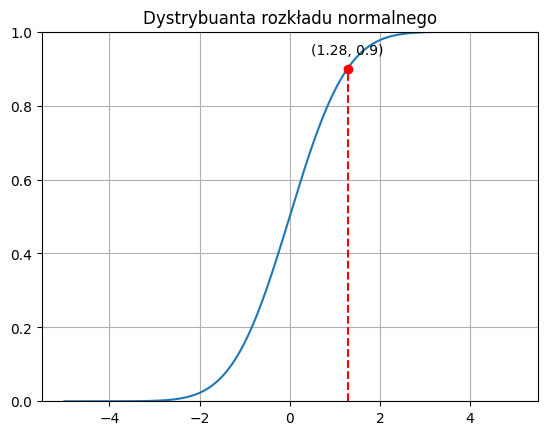

In [6]:
P = 0.9
xP = inverseDistribuant(P)
x = np.linspace(-5, 5, 1000)
y = distribuant(x)
plt.plot(x, y)
plt.plot([xP, xP], [0, P], 'r--')
plt.plot(xP, P, 'ro')
plt.annotate(f'({xP:.2f}, {P})', (xP, P), textcoords="offset points", xytext=(0,10), ha='center')
plt.ylim(0, 1)
plt.title('Dystrybuanta rozkładu normalnego')
plt.grid(True)
plt.show()

W moim rozwiązaniu jednak ta analiza nie była konieczna, ponieważ użycie <i>scipy.stats.norm.ppf()</i> pozwala na obliczenie wartości odwrotnej dystrybuanty normalnej o dowolnych parametrach.

### Źródła

Kod był napisany przeze mnie, a swoją wiedzę opierałem o materiały dostępne w internecie, takie jak:

<ul>
<li><a href="http://staff.uz.zgora.pl/mpatan/materialy/badoper/wyklady/druk_6z.pdf">Maciej Patan, Programowanie sieciowe. Metody CPM i PERT </a></li>
<li><a href="https://www.youtube.com/watch?v=7qSPc5H7q0E&ab_channel=Jako%C5%9B%C4%87zarz%C4%85dzania">Wykres Gantta</a></li>
<li><a href="https://www.youtube.com/watch?v=-TDh-5n90vk&ab_channel=JoshuaEmmanuel">Project Scheduling - PERT/CPM | Finding Critical Path</a></li>
<li><a href="https://www.youtube.com/watch?v=LLg_FUvrbG0&ab_channel=EngineerBoyOfficial">How to use PERT Method ? project management</a></li>

<ul>
